# Homework 2 - Problem 2
### Optimization theory with applications


#### Andrea Senacheribbe
---

The minimisation problem we are considering is:

$$ \min_{x}{f(x)} \quad \textit{st} \quad \sum_{i=1}^{m} x_i \le 100 \quad \textit{and} \quad x_i \ge 0, \forall i \ge 1 $$

where
$f(x_1, x_2, ..., x_m)= \sum_{i=1}^{m} a_i(x_i-b_i)^2 + 3$ $\quad$

---

We can derive the Lagrangian, by rewriting the inequalities in the form $h_i(x)\le 0$ and introducing the multipliers $u$:

$$\mathcal{L} (x,u)= f(x) + u_0\left(\sum_i{x_i} -100\right) + u_{1...m}^T(-x)$$
Note that $u$ is a vector with $m+1$ elements: $u_0$ is associated with the constraint on the summation, while  $u_{1...m}$ with the constraints on the individual $x_i$. Notice that the index $i$ in $x_i$ starts from 1.


The dual problem becomes therefore



$$\max_{u}{g(u)} \quad \textit{st} \quad u_i\ge0, \forall i$$

where $g(u)= \min_{x}{\mathcal{L} (x,u)}$


## 1) KKT conditions

We can write the KKT conditions as follow

1) stationarity 
$$ \frac{\partial \mathcal{L}}{\partial x_i} = 2 a_i (x_i - b_i) +u_0 - u_i = 0$$


2) complementary slackness
$$ u_0\left(\sum_i{x_i} -100\right) = 0$$
$$ u_i x_i =0,\, \forall i \ge 1$$


3) primal feasibility
$$\sum_{i} x_i \le 100$$
$$-x_i \le 0, \forall i \ge 1$$



4) dual feasibility
$$u_i\ge0,\, \forall i$$


### Some insights on the problem using the KKT
From 1) and 2) for a generic $i\ge 1$ we can state the following

$\textit{if} \quad  x_i\neq 0 \implies u_i = 0 $

$\quad  2 a_i (x_i - b_i) + u_0 = 0 \iff x_i = b_i - \frac{u_0}{2 a_i}$

Since $ x_i > 0 $, we have $ b_i - \frac{ u_{0} }{2 a_i} = x_i >  0 \implies u_{0} < 2 a_i b_i $

---

From 1) and 4) we can write

$ 2 a_i (x_i - b_i) +u_{0} = u_i \ge 0 \implies  2 a_i (x_i - b_i) +u_{0} \ge 0 \implies  x_i \ge b_i - \frac{u_{0}}{2 a_i}$

We can use this result to derive the complementary case of above, using again 2)

$\textit{if} \quad  u_i\neq 0 \implies x_i = 0$

$\quad 0= x_i \ge b_i - \frac{u_0}{2 a_i} \implies u_{0} \ge 2 a_i b_i  $

---
Overall we can write then

$x_i=\begin{cases}
    b_i - \frac{u_{0}}{2 a_i} & u_{0} < 2 a_i b_i\\
    0 & u_0 \ge 2 a_i b_i
  \end{cases}$
  
or equivalenty $x_i=max(0, b_i - \frac{u_{0}}{2 a_i})$. To have $x$ feasible we should also impose $\sum_{i} x_i \le 100$.

With this method we didn't end with a complete analytic solution, but we can at least understand the actual form of the solution.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
f = lambda x,a,b: np.sum(a*((x-b)**2))+3

In [3]:
np.random.seed(1)

In [4]:
m=500
a=np.random.randint(1,100+1, size=m)
b=np.random.randint(1,100+1, size=m)
a.shape, b.shape

((500,), (500,))

## 2) Dual ascent

The dual ascent algorithm allows to solve a minimisation problem with equalities and inequalities constraints, by maximising the dual of $f$.

Our optimisation problem can be reformulated as

$$\min_{x}{f(x)} \quad \textit{st} \quad  Cx \le d $$

where $C$ is a matrix $(m+1, m)$, associated with the constrain reported above.

In particular the first row of C is full of ones to represent the constraint $\sum_{i} x_i \le 100$, while the other $m$ rows have $-1$ on the diagonal, and represent the constraints $-x_i \le 0, \forall i \ge 1$

In [5]:
C=np.concatenate([np.ones((1,m)),-np.eye(m)],axis=0)
C

array([[ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [-1., -0., -0., ..., -0., -0., -0.],
       [-0., -1., -0., ..., -0., -0., -0.],
       ...,
       [-0., -0., -0., ..., -1., -0., -0.],
       [-0., -0., -0., ..., -0., -1., -0.],
       [-0., -0., -0., ..., -0., -0., -1.]])

In [6]:
C.shape

(501, 500)

---

$d$ is instead formed by putting $100$ in the first row (for the copuling constraint on the summation) and $0$ elsewhere. 

In [7]:
d=np.zeros(m+1, dtype=np.float64)
d[0]=100
d[:4] # printing first 4 rows

array([100.,   0.,   0.,   0.])

---

To compare the result with our algorithm, we firstly solve the problem using ```scipy.optimize``` 

In [8]:
from scipy.optimize import LinearConstraint, minimize

# here optimise sqrt(f(x)), since grows less rapidly and allow better convergence of the algorithm
# x that minimises this problem will be the same of our problem
min_sol=minimize(lambda x: np.sqrt(f(x,a,b)),np.ones(m), constraints=LinearConstraint(C,-np.inf, d))
f_opt=f(min_sol.x, a,b)
min_sol.success, min_sol.message, f_opt

(True, 'Optimization terminated successfully.', 80630285.25494224)

---

Essentially the dual ascent algorithm works by doing gradient ascent on the dual variable $u$ and updating at each iteration the value $x$ by solving a minimisation problem.

$$
x^{k+1}= argmin_{x}{(f(x) + (u ^k)^T C x)}$$
and
$$
u^{k+1}=max(u^k+t_k ( A x^{k+1} -b),0)
$$

---
For our case we can derive a closed form for the argmin, by simply computing the gradient and setting it equal to 0:

$$ 
\nabla f(x) + (u ^k)^T C  =0
$$
therefore
$$
2 a_i (x_i - b_i) +(u ^k)^T C_i =0 \implies x_i=b_i - \frac{(u ^k)^T C_i}{2a_i}
$$

To help the algorithm we can clip to zero all the negative values of $x_i$ (recall that $x_i$ should be non negative).
Notice that this step is not part of the dual ascend algorithm (indeed the algorithm works even when not clipping the negative values to 0), but from our tests this provides faster and better convergence.

In [9]:
argmin_f=lambda u: np.maximum(b-(u@C)/(2*a),0)

In [10]:
def dual_ascent(u0, argmin, fun, t, C, d, eps=1e-5, max_iter=10000):
    assert(u0.shape[0]==C.shape[0]==d.shape[0])
    n_var,n_con=C.shape[1], u0.size
    
    x=np.empty(n_var, dtype=np.float64)
    u=np.empty(n_con, dtype=np.float64)
    f=np.empty(max_iter, dtype=np.float64)
    
    u=u0.copy()
    
    for k in range(max_iter-1):
        
        # solve argmin problem
        x=argmin(u)
        f[k]=fun(x)
        
        if  np.abs(f[k]-f[k-1]) < eps:
            print("converged after %d iterations" % k)
            break

        #update u

        u=np.maximum(u+t*(C@x-d),0)
        
    else: #reached max_iter-1
        k=max_iter-1
        x=argmin(u)
        f[k]=fun(x)

        print("stopped since reached max_iter")
        
    
    return x, f[:k+1]

In [11]:
u0=np.ones(m+1)
u0.shape

(501,)

In [12]:
t=0.15

In [13]:
x_da,f_da=dual_ascent(u0, argmin_f ,lambda x: f(x,a,b), t, C, d, max_iter=5000, eps=1e-4)

converged after 1977 iterations


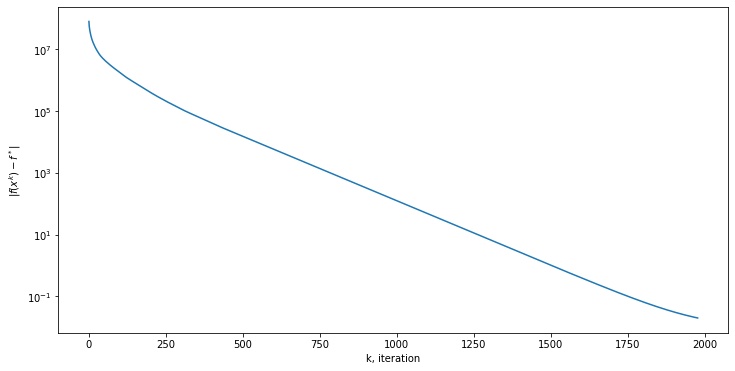

In [14]:
plt.figure(figsize=(12,6))

plt.semilogy(np.abs(f_da-f_opt))

plt.ylabel("$|f(x^{k}) - f^*|$")
plt.xlabel("k, iteration");

Notice that all the constraints are respected:

In [15]:
print("sum(x_i) =\t\t %.5f" % np.sum(x_da), "\n# negatives x_i =\t",np.sum(x_da<0))

sum(x_i) =		 100.00000 
# negatives x_i =	 0


### Analysis

In the plot above, we report $|f(x^{k}) - f^*|$, that is the distance of the value of the function from the optimal computed before using ```scipy.optimize```.
Notice that it is not meaningful to plot  $f(x^{k})$. The step of the dual ascent is not always a descent on $f(x)$ since it takes care also of the constraints (the function can increase at some point if it doesn't respect the constraints).


By a trial and error proceedure, we concluded that $t=0.15$ yields the best convergence. As we can notice from the plot, the convergence is exponential (linear in log scale).

For stopping condition, we can no longer use the check on the norm of the gradient (as we did in Problem 1), since now this may not converge to 0. Indeed for the gradient ascent in the variable $u$,  $\nabla g(u)=C x -d$ and this will tend to be $Cx -d \le 0$ (since it's a constraint of our minimisation problem).

A reasonable choice seems to check the difference of the function we want to minimise ($f(x)$) with respect its value in the previous iteration: if the function is not changing we stop the execution. Therefore the stopping condition is $|f(x_{k})- f(x_{k-1})|<\epsilon$

## 3) Parallelisation

The solution can be parallelised using dual decomposition. Indeed since the function to minimise can be decomposed in $m$ terms $f_i(x_i)$ that depends only on one variable $x_i$ (recall $f(x_1, x_2, ..., x_m)= \sum_{i=1}^{m} a_i(x_i-b_i)^2 + 3$ ).

This allows to split the argmin problem like follows:
$$ x^{k+1}= argmin_{x}{(f(x) + (u ^k)^T C x)} \iff x^{k+1}_i= argmin_{x_i}{(f_i(x_i) + (u ^k)^T C_i x_i)} $$

In this way, we don't reduce the number of iterations required, because after each iteration we still need to gather all the $x_i$ and compute the updated $u^{k}$.

Anyway this decomposition can speed up the execution time, since different cores/processors can run smaller argmin problems in parallel and so each iteration lasts less time.